In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [4]:
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("husl")

COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [3]:
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.head()}")
    print(f"Test Data Shape: {df_test.tail()}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    # Fallback to local directory if paths are different
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)


Training Data Shape:    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0

In [5]:
attack_mapping = {
    'normal': 'normal',
    
    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    
    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())

Training Class Distribution:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [6]:
categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

print(df_train.isnull())

Categorical Features: 3
Binary Features: 4
Numerical Features: 34
        duration  protocol_type  service   flag  src_bytes  dst_bytes   land  \
0          False          False    False  False      False      False  False   
1          False          False    False  False      False      False  False   
2          False          False    False  False      False      False  False   
3          False          False    False  False      False      False  False   
4          False          False    False  False      False      False  False   
...          ...            ...      ...    ...        ...        ...    ...   
125968     False          False    False  False      False      False  False   
125969     False          False    False  False      False      False  False   
125970     False          False    False  False      False      False  False   
125971     False          False    False  False      False      False  False   
125972     False          False    False  False      F

In [7]:

def clean_outliers_isolation_forest(df,contamination = 0.01):
    iso_df  = df[numerical_features].copy()

    clf = IsolationForest(max_samples='auto',contamination = contamination, random_state = 42)

    outliers = clf.fit_predict(iso_df)

    n_outliers = (outliers == -1).sum()
    print(f"Identifies {n_outliers} Outlilers using the Isolation forest")

    return outliers
df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)

Identifies 1256 Outlilers using the Isolation forest


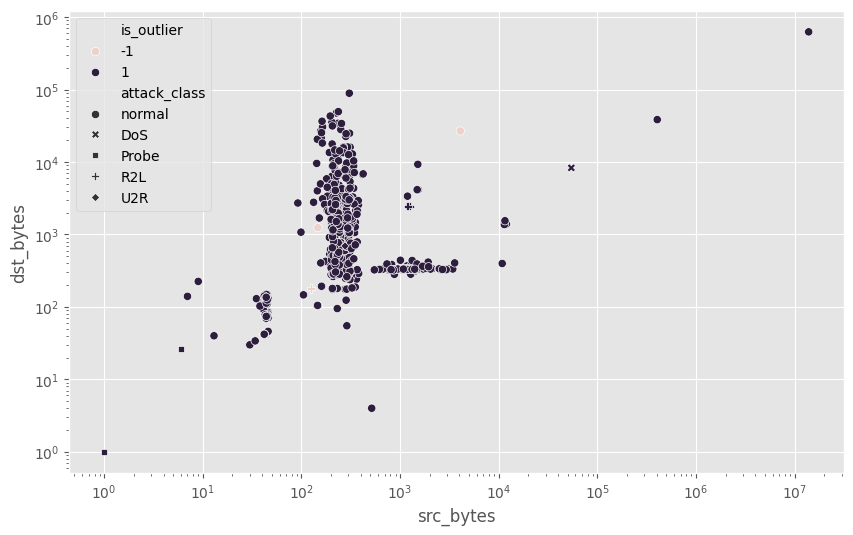

In [8]:

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train[::100], x = 'src_bytes', y = 'dst_bytes', hue='is_outlier', style='attack_class')
plt.xscale('log')
plt.yscale('log')
plt.show()

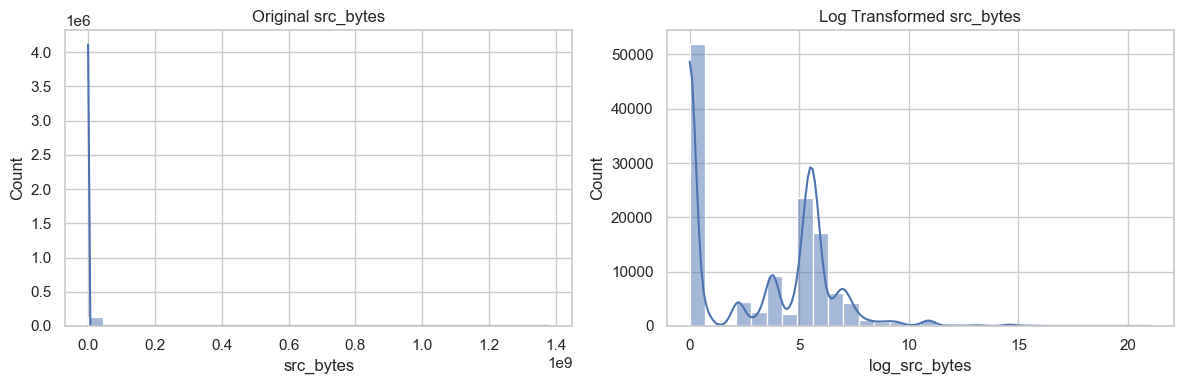

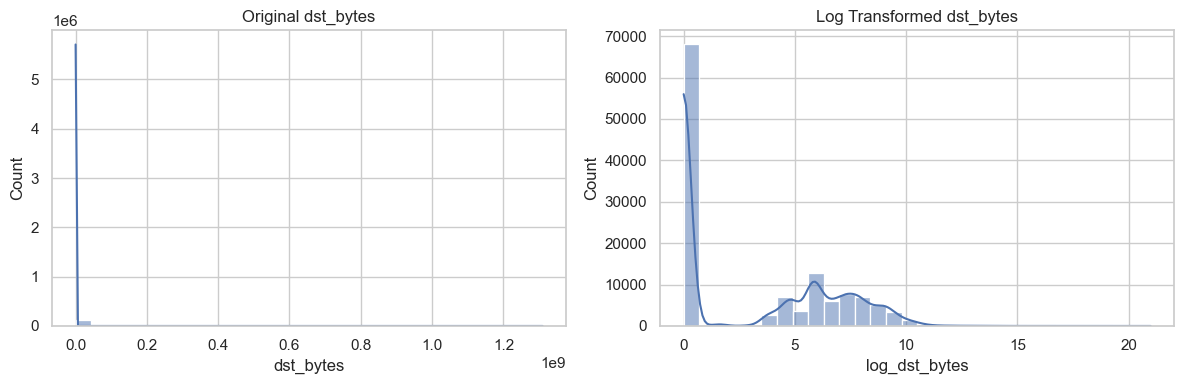

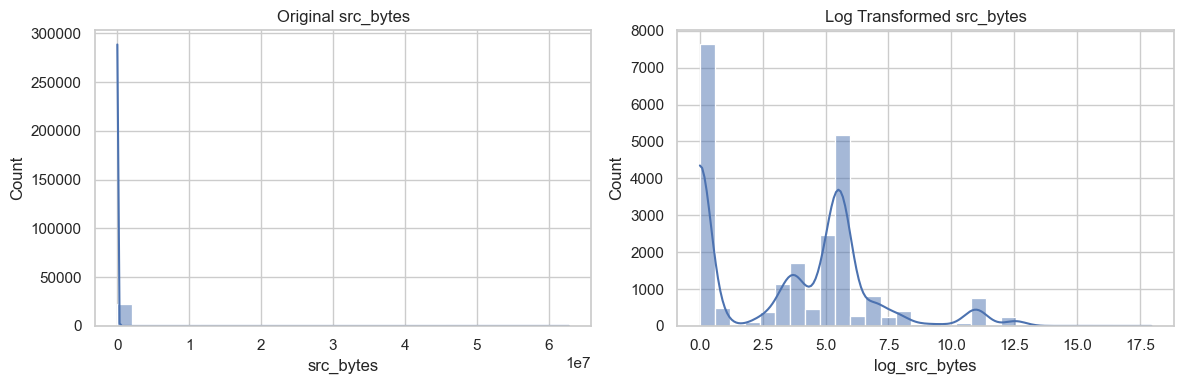

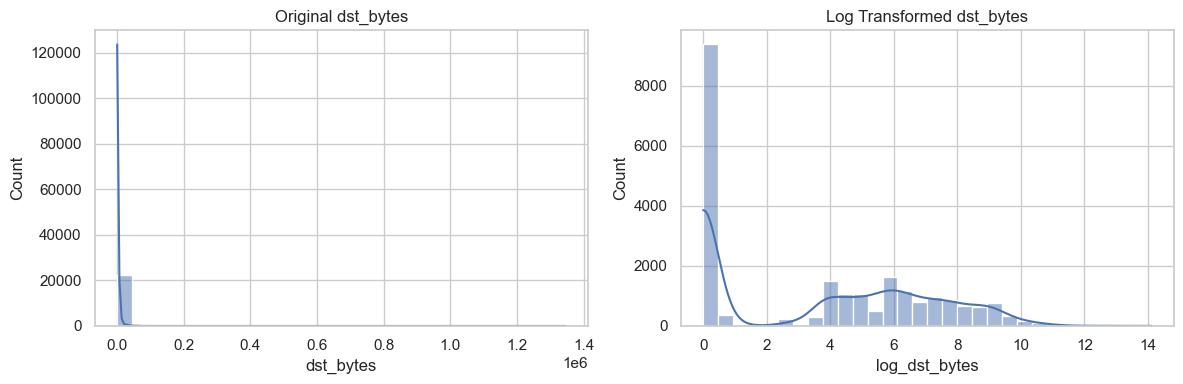

Original Correlation Matrix:
           src_bytes  dst_bytes
src_bytes   1.000000   0.000204
dst_bytes   0.000204   1.000000

Log-Transformed Correlation Matrix:
               log_src_bytes  log_dst_bytes
log_src_bytes        1.00000        0.70235
log_dst_bytes        0.70235        1.00000


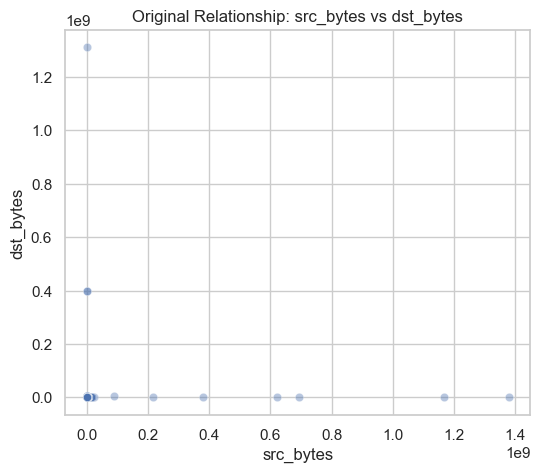

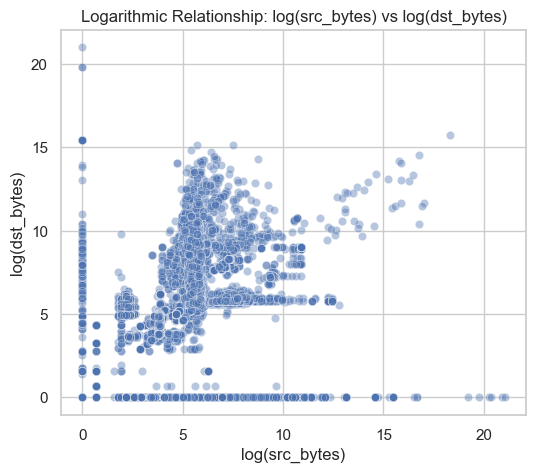


Summary:
• Log transformation reduced skewness
• Log-transformed features show stronger linear correlation
• Suitable for ML models like Linear Regression, SVM, KNN


In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def apply_log_transform(df, cols):
    """
    Applies log1p transformation to selected columns
    and plots original vs transformed distributions
    """
    df_transform = df.copy()

    for col in cols:
        new_col = f"log_{col}"
        df_transform[new_col] = np.log1p(df_transform[col])

        # Plot distributions
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f"Original {col}")

        plt.subplot(1, 2, 2)
        sns.histplot(df_transform[new_col], bins=30, kde=True)
        plt.title(f"Log Transformed {col}")

        plt.tight_layout()
        plt.show()

    return df_transform

skewed_cols = ['src_bytes', 'dst_bytes']

df_train = apply_log_transform(df_train, skewed_cols)
df_test = apply_log_transform(df_test, skewed_cols)

original_corr = df_train[['src_bytes', 'dst_bytes']].corr()
print("Original Correlation Matrix:")
print(original_corr)

log_corr = df_train[['log_src_bytes', 'log_dst_bytes']].corr()
print("\nLog-Transformed Correlation Matrix:")
print(log_corr)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=df_train['src_bytes'],
    y=df_train['dst_bytes'],
    alpha=0.4
)
plt.title("Original Relationship: src_bytes vs dst_bytes")
plt.xlabel("src_bytes")
plt.ylabel("dst_bytes")
plt.show()

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=df_train['log_src_bytes'],
    y=df_train['log_dst_bytes'],
    alpha=0.4
)
plt.title("Logarithmic Relationship: log(src_bytes) vs log(dst_bytes)")
plt.xlabel("log(src_bytes)")
plt.ylabel("log(dst_bytes)")
plt.show()

print("\nSummary:")
print("• Log transformation reduced skewness")
print("• Log-transformed features show stronger linear correlation")
print("• Suitable for ML models like Linear Regression, SVM, KNN")